In [1]:
### Son kod ###

import cv2
from ultralytics import YOLO

# YOLOv8 modellerini yükle (ana model ve ikinci model)
main_model = YOLO(r'C:\Users\tahay\OneDrive\Masaüstü\FaceDetection\head_detection.pt')
secondary_model = YOLO(r'C:\Users\tahay\OneDrive\Masaüstü\FaceDetection\face_zoom_m.pt')

# Bilgisayarın ön kamerasını aç
cap = cv2.VideoCapture(0)

# Güven skoru için eşik değeri belirle
confidence_threshold = 0.8

# Zoom oranı için bir ölçek faktörü tanımla (1.5 zoom oranını azaltır)
scale_factor = 1.5

while True:
    # Kameradan bir kare yakala
    ret, frame = cap.read()
    
    if not ret:
        break

    # Görüntüyü yatay olarak çevir
    frame = cv2.flip(frame, 1)

    # Ana YOLO modelini kullanarak yüz algılaması yap
    results = main_model(frame)

    # Tespit edilen yüzleri çerçevelerle göster
    zoomed_frame = None  # Zoom yapılmış görüntü için bir değişken oluştur

    for r in results:
        boxes = r.boxes
        for box in boxes:
            confidence = box.conf[0].item()  # Güven skoru

            # Güven skoru eşik değerinden büyükse işlemi gerçekleştir
            if confidence >= confidence_threshold:
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # Çerçeve koordinatlarını al

                # Zoom alanını genişletmek için boyutları artır
                w = x2 - x1
                h = y2 - y1
                x1 = max(0, x1 - int(w * (scale_factor - 1) / 2))
                y1 = max(0, y1 - int(h * (scale_factor - 1) / 2))
                x2 = min(frame.shape[1], x2 + int(w * (scale_factor - 1) / 2))
                y2 = min(frame.shape[0], y2 + int(h * (scale_factor - 1) / 2))
                
                cls = int(box.cls[0])  # Sınıf kimliği
                
                # Sınıf ismini al
                label = main_model.names[cls]  
                
                # Çerçeveyi çiz ve sınıf bilgisi ile güven skoru yaz
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(frame, f'{label} {confidence:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                
                # Zoom yapılmış görüntüyü oluştur
                zoomed_frame = frame[y1:y2, x1:x2]

    # Zoom yapılmış kare mevcut değilse, boş bir kare oluştur
    if zoomed_frame is None:
        zoomed_frame = cv2.resize(frame, (frame.shape[1] // 2, frame.shape[0] // 2))
    else:
        # Zoom yapılmış kareyi yeniden boyutlandır
        zoomed_frame = cv2.resize(zoomed_frame, (frame.shape[1] // 2, frame.shape[0] // 2))
        
        # İkinci YOLO modelini zoom yapılmış kare üzerinde kullan
        zoomed_results = secondary_model(zoomed_frame)
        
        for r in zoomed_results:
            boxes = r.boxes
            for box in boxes:
                confidence = box.conf[0].item()  # Güven skoru

                # Güven skoru eşik değerinden büyükse işlemi gerçekleştir
                if confidence >= confidence_threshold:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Çerçeve koordinatlarını al
                    cls = int(box.cls[0])  # Sınıf kimliği
                    
                    # Sınıf ismini al
                    label = secondary_model.names[cls]  
                    
                    # Çerçeveyi çiz ve sınıf bilgisi ile güven skoru yaz
                    cv2.rectangle(zoomed_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(zoomed_frame, f'{label} {confidence:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                    # Metni zoomed_frame'in ortasına yerleştir
                    text = f'{label} {confidence:.2f}'
                    text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
                    text_x = (zoomed_frame.shape[1] - text_size[0]) // 2
                    text_y = (zoomed_frame.shape[0] + text_size[1]) // 2
                    cv2.putText(zoomed_frame, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Ekranın iki yarısında gösterilecek şekilde görüntüleri birleştir
    combined_frame = cv2.hconcat([frame, cv2.resize(zoomed_frame, (frame.shape[1] // 2, frame.shape[0]))])

    # Son görüntüyü 1920x1080 boyutuna yeniden boyutlandır
    combined_frame = cv2.resize(combined_frame, (1920, 1080))

    # Sonuçları göster
    cv2.imshow('YOLOv8 Face Detection - Full and Zoomed', combined_frame)

    # 'q' tuşuna basıldığında döngüden çık
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Kamerayı ve pencereleri serbest bırak
cap.release()
cv2.destroyAllWindows()


0: 672x864 2 0s, 252.1ms
Speed: 12.5ms preprocess, 252.1ms inference, 13.0ms postprocess per image at shape (1, 3, 672, 864)

0: 672x864 (no detections), 956.7ms
Speed: 9.0ms preprocess, 956.7ms inference, 1.0ms postprocess per image at shape (1, 3, 672, 864)

0: 672x864 2 0s, 164.1ms
Speed: 10.0ms preprocess, 164.1ms inference, 2.0ms postprocess per image at shape (1, 3, 672, 864)

0: 672x864 1 Taha, 814.8ms
Speed: 9.0ms preprocess, 814.8ms inference, 2.0ms postprocess per image at shape (1, 3, 672, 864)

0: 672x864 2 0s, 154.1ms
Speed: 7.0ms preprocess, 154.1ms inference, 1.0ms postprocess per image at shape (1, 3, 672, 864)

0: 672x864 1 Cankut, 1 Taha, 776.3ms
Speed: 6.0ms preprocess, 776.3ms inference, 2.0ms postprocess per image at shape (1, 3, 672, 864)

0: 672x864 2 0s, 144.1ms
Speed: 8.0ms preprocess, 144.1ms inference, 2.0ms postprocess per image at shape (1, 3, 672, 864)

0: 672x864 1 Taha, 758.9ms
Speed: 6.0ms preprocess, 758.9ms inference, 1.0ms postprocess per image at s

In [1]:
#### Ses sahibi tespit edilmiş sistem son. 

import tkinter as tk
from tkinter import ttk
from tensorflow.keras.models import load_model
import sounddevice as sd
import numpy as np
from scipy.io.wavfile import write
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

def audio_to_fft(audio, samplerate):
    fft = np.fft.fft(audio)
    fft = np.abs(fft)
    fft = fft[:samplerate // 2]
    return fft

def record_audio(duration, samplerate=16000):
    recording = sd.rec(int(samplerate * duration), samplerate=samplerate, channels=1, dtype='float32')
    for i in range(duration):
        progress_bar['value'] += 10  # Progress bar'ı güncelle
        window.update_idletasks()
        sd.sleep(1000)  # 1 saniye bekle
    sd.wait()
    return recording.squeeze()

def process_audio(audio, samplerate=16000):
    fft = audio_to_fft(audio, samplerate)
    fft = fft.reshape(1, -1)
    return fft

def update_plot(audio_data, samplerate):
    fft = audio_to_fft(audio_data, samplerate)
    line.set_ydata(fft)
    line.set_xdata(np.arange(len(fft)))
    canvas.draw()

def recognize_and_check():
    progress_bar['value'] = 0  # Progress bar'ı sıfırla
    duration = 10
    samplerate = 16000
    audio = record_audio(duration, samplerate)

    segment_length = samplerate
    segments = [audio[i:i + segment_length] for i in range(0, len(audio), segment_length)]

    predictions = []
    for i, segment in enumerate(segments):
        processed_audio = process_audio(segment, samplerate)
        prediction = model.predict(processed_audio)
        predicted_class = np.argmax(prediction, axis=-1)
        predictions.append(predicted_class[0])
        update_plot(segment, samplerate)  # Grafik güncelleme

    detected_class = class_names[max(set(predictions), key=predictions.count)]  # En çok tespit edilen sınıf
    if detected_class == "Taha":
        result_label.config(text=f"Ana kullanıcı ({detected_class}) tespit edildi, bir sonraki aşamaya geçebilirsiniz.")
    elif detected_class == "Cankut":
        result_label.config(text=f"İkincil tanımlı kullanıcı ({detected_class}) tespit edildi, ikinci aşamaya geçebilirsiniz.")
    else:
        result_label.config(text=f"İzinsiz giriş denemesi tespit edildi, lütfen arabadan uzaklaşın.")

# Ana arayüz
window = tk.Tk()
window.title("Sesle Kullanıcı Tanıma")
window.geometry("600x450")

class_names = ['Zeynep', 'Cankut', 'Taha', 'Selin', 'Evrim', 'Mehmet', '.ipynb_checkpoints', 'Kaan', 'Huseyin', 'Merve']
model = load_model(r'C:\Users\tahay\OneDrive\Masaüstü\FaceDetection\my_model.h5')

instructions_label = tk.Label(window, text="Ses kaydını başlatmak için butona basın")
instructions_label.pack(pady=10)

result_label = tk.Label(window, text="", font=("Arial", 12), fg="blue")
result_label.pack(pady=10)

start_button = tk.Button(window, text="Başlat", command=recognize_and_check)
start_button.pack(pady=10)

# Progress bar ekleme
progress_bar = ttk.Progressbar(window, orient='horizontal', length=400, mode='determinate', maximum=100)
progress_bar.pack(pady=20)

# Ses frekansını göstermek için matplotlib grafiği
fig, ax = plt.subplots()
line, = ax.plot(np.zeros(8000))
ax.set_ylim(0, 1)
ax.set_xlim(0, 8000)

canvas = FigureCanvasTkAgg(fig, master=window)
canvas.get_tk_widget().pack()

window.mainloop()


ModuleNotFoundError: No module named 'tensorflow'

In [34]:
#!pip install vosk
#!pip install sounddevice

In [22]:
!pip install SpeechRecognition

  Obtaining dependency information for SpeechRecognition from https://files.pythonhosted.org/packages/e6/28/b5e6e769002e46a5edef16871884721d4b68da31dbd4509db6ea50f8b224/SpeechRecognition-3.10.4-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/32.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/32.8 MB 1.3 MB/s eta 0:00:26
   ---------------------------------------- 0.1/32.8 MB 1.1 MB/s eta 0:00:32
   ---------------------------------------- 0.2/32.8 MB 1.5 MB/s eta 0:00:23
   ---------------------------------------- 0.4/32.8 MB 2.1 MB/s eta 0:00:16
    --------------------------------------- 0.6/32.8 MB 2.7 MB/s eta 0:00:12
   - -------------------------------------- 0.9/32.8 MB 3.3 MB/s eta 0:00:10
   - -------------------------------------- 1.2/32.8 MB 4.0 MB/s eta 0:00:08
   - -------------------------------------- 1.4/32.8 MB 4.1 MB/s eta 0:00:08
   - -------------------------------------- 1.4/32.8 MB 3.9 MB/s eta 0:00:09
   - --------

In [7]:
import speech_recognition as sr

# Şifreler
normal_password = "açıl susam açıl"
emergency_password = "susam susam açıl"

# Polisi arama fonksiyonu (simülasyon)
def call_police():
    print("Polis aranıyor... (Simülasyon)")

# Ses tanıma ve şifre kontrolü
def recognize_speech():
    recognizer = sr.Recognizer()
    with sr.Microphone() as source:
        print("Konuşun (Çıkmak için Ctrl+C):")
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.listen(source)

        try:
            text = recognizer.recognize_google(audio, language="tr-TR")
            print("Söylenen:", text)

            if text.lower() == normal_password:
                print("Kilit Açıldı")

            elif text.lower() == emergency_password:
                print("Kilit Açıldı")
                call_police()

            else:
                print("Şifre yanlış!")

        except sr.UnknownValueError:
            print("Ne dediğinizi anlayamadım")
        except sr.RequestError as e:
            print(f"Google Web Speech API'ye ulaşırken bir hata oluştu: {e}")

try:
    recognize_speech()
except KeyboardInterrupt:
    print("Program sonlandırıldı.")
except Exception as e:
    print(f"Bir hata oluştu: {str(e)}")


Konuşun (Çıkmak için Ctrl+C):
Söylenen: susam susam açıl
Kilit Açıldı
Polis aranıyor... (Simülasyon)


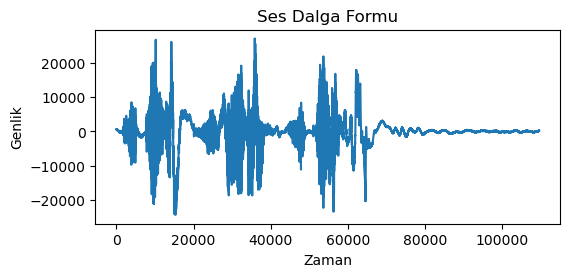

In [61]:
##### SON HALİ ###
import tkinter as tk
from tkinter import Frame
import speech_recognition as sr
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np

# Şifreler
normal_password = "açıl susam açıl"
emergency_password = "susam susam açıl"

# Polisi arama fonksiyonu (simülasyon)
def call_police():
    result_label.config(text="Polis aranıyor... (Simülasyon)")

# Ses tanıma ve şifre kontrolü
def recognize_speech():
    recognizer = sr.Recognizer()
    with sr.Microphone() as source:
        result_label.config(text="Konuşun...")
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.listen(source)

        # Ses dalgalarını görselleştirme
        audio_data = np.frombuffer(audio.get_raw_data(), dtype=np.int16)
        plot_waveform(audio_data)

        try:
            text = recognizer.recognize_google(audio, language="tr-TR")
            result_label.config(text=f"Söylenen: {text}")

            if text.lower() == normal_password:
                result_label.config(text="Kilit Açıldı")

            elif text.lower() == emergency_password:
                result_label.config(text="Kilit Açıldı")
                call_police()

            else:
                result_label.config(text="Şifre yanlış!")

        except sr.UnknownValueError:
            result_label.config(text="Ne dediğinizi anlayamadım")
        except sr.RequestError as e:
            result_label.config(text=f"Google Web Speech API'ye ulaşırken bir hata oluştu: {e}")

# Ses dalgalarını görselleştirme fonksiyonu
def plot_waveform(audio_data):
    fig, ax = plt.subplots()
    ax.plot(audio_data)
    ax.set_title("Ses Dalga Formu")
    ax.set_xlabel("Zaman")
    ax.set_ylabel("Genlik")

    canvas = FigureCanvasTkAgg(fig, master=window)
    canvas.draw()
    canvas.get_tk_widget().pack(pady=10)

# Giriş sayfasına geçiş
def go_to_login_page():
    start_frame.pack_forget()
    login_frame.pack()

# Arayüzü (UI) oluşturma
window = tk.Tk()
window.title("Sesle Şifre Doğrulama")

# Ekran boyutunu ayarlama
window.geometry("600x400")

# Başlangıç sayfası
start_frame = Frame(window)
start_frame.pack()

welcome_label = tk.Label(start_frame, text="Hoşgeldiniz!", font=("Arial", 24))
welcome_label.pack(pady=20)

go_to_login_button = tk.Button(start_frame, text="Giriş Yap", command=go_to_login_page)
go_to_login_button.pack(pady=10)

# Şifre kayıt sayfası
login_frame = Frame(window)

instructions_label = tk.Label(login_frame, text="Şifre doğrulamak için butona basın ve konuşun:")
instructions_label.pack(pady=10)

start_button = tk.Button(login_frame, text="Şifre Kaydını Başlat", command=recognize_speech)
start_button.pack(pady=10)

result_label = tk.Label(login_frame, text="")
result_label.pack(pady=10)

# Uygulamanın çalışması
window.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\tahay\anaconda3\envs\YOLOV\Lib\site-packages\speech_recognition\__init__.py", line 108, in get_pyaudio
    import pyaudio
ModuleNotFoundError: No module named 'pyaudio'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\tahay\anaconda3\envs\YOLOV\Lib\tkinter\__init__.py", line 1967, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\tahay\AppData\Local\Temp\ipykernel_12188\1779150237.py", line 80, in recognize_speech
    with sr.Microphone() as source:
         ^^^^^^^^^^^^^^^
  File "C:\Users\tahay\anaconda3\envs\YOLOV\Lib\site-packages\speech_recognition\__init__.py", line 80, in __init__
    self.pyaudio_module = self.get_pyaudio()
                          ^^^^^^^^^^^^^^^^^^
  File "C:\Users\tahay\anaconda3\envs\YOLOV\Lib\site-packages\speech_recognition\__init__.py", line 110, in get_pyaudio
    r

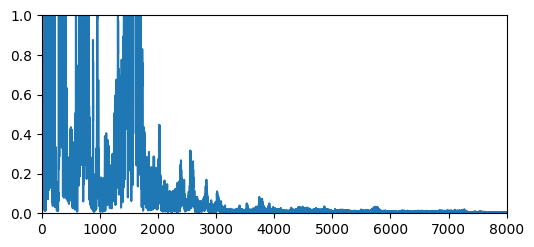

In [11]:
## Kombine edilmiş kod

import tkinter as tk
from tkinter import ttk, Frame
from tensorflow.keras.models import load_model
import sounddevice as sd
import numpy as np
from scipy.io.wavfile import write
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import speech_recognition as sr

# İlk uygulama fonksiyonları
def audio_to_fft(audio, samplerate):
    fft = np.fft.fft(audio)
    fft = np.abs(fft)
    fft = fft[:samplerate // 2]
    return fft

def record_audio(duration, samplerate=16000):
    recording = sd.rec(int(samplerate * duration), samplerate=samplerate, channels=1, dtype='float32')
    for i in range(duration):
        progress_bar['value'] += 10  # Progress bar'ı güncelle
        window.update_idletasks()
        sd.sleep(1000)  # 1 saniye bekle
    sd.wait()
    return recording.squeeze()

def process_audio(audio, samplerate=16000):
    fft = audio_to_fft(audio, samplerate)
    fft = fft.reshape(1, -1)
    return fft

def update_plot(audio_data, samplerate):
    fft = audio_to_fft(audio_data, samplerate)
    line.set_ydata(fft)
    line.set_xdata(np.arange(len(fft)))
    canvas.draw()

def recognize_and_check():
    progress_bar['value'] = 0  # Progress bar'ı sıfırla
    duration = 10
    samplerate = 16000
    audio = record_audio(duration, samplerate)

    segment_length = samplerate
    segments = [audio[i:i + segment_length] for i in range(0, len(audio), segment_length)]

    predictions = []
    for i, segment in enumerate(segments):
        processed_audio = process_audio(segment, samplerate)
        prediction = model.predict(processed_audio)
        predicted_class = np.argmax(prediction, axis=-1)
        predictions.append(predicted_class[0])
        update_plot(segment, samplerate)  # Grafik güncelleme

    detected_class = class_names[max(set(predictions), key=predictions.count)]  # En çok tespit edilen sınıf
    if detected_class == "Taha":
        result_label.config(text=f"Ana kullanıcı ({detected_class}) tespit edildi, son  aşamaya geçebilirsiniz.")
        open_second_application()
    elif detected_class == "Cankut":
        result_label.config(text=f"Ana kullanıcı ({detected_class}) tespit edildi, son aşamaya geçebilirsiniz.")
        open_second_application()
    elif detected_class == "Zeynep":
        result_label.config(text=f"Ana kullanıcı ({detected_class}) tespit edildi, son aşamaya geçebilirsiniz.")
        open_second_application()
  
    else:
        result_label.config(text=f"İzinsiz giriş denemesi tespit edildi, lütfen arabadan uzaklaşın.")

# İkinci uygulama fonksiyonları
normal_password = "açıl susam açıl"
emergency_password = "susam susam açıl"

def call_police():
    result_label_second.config(text="Polis aranıyor... (Simülasyon)")

def recognize_speech():
    recognizer = sr.Recognizer()
    with sr.Microphone() as source:
        result_label_second.config(text="Konuşun...")
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.listen(source)

        # Ses dalgalarını görselleştirme
        audio_data = np.frombuffer(audio.get_raw_data(), dtype=np.int16)
        plot_waveform(audio_data)

        try:
            text = recognizer.recognize_google(audio, language="tr-TR")
            result_label_second.config(text=f"Söylenen: {text}")

            if text.lower() == normal_password:
                result_label_second.config(text="Kilit Açıldı")
            elif text.lower() == emergency_password:
                result_label_second.config(text="Kilit Açıldı")
                call_police()
            else:
                result_label_second.config(text="Şifre yanlış!")
        except sr.UnknownValueError:
            result_label_second.config(text="Ne dediğinizi anlayamadım")
        except sr.RequestError as e:
            result_label_second.config(text=f"Google Web Speech API'ye ulaşırken bir hata oluştu: {e}")

def plot_waveform(audio_data):
    fig, ax = plt.subplots()
    ax.plot(audio_data)
    ax.set_title("Ses Dalga Formu")
    ax.set_xlabel("Zaman")
    ax.set_ylabel("Genlik")

    canvas = FigureCanvasTkAgg(fig, master=second_window)
    canvas.draw()
    canvas.get_tk_widget().pack(pady=10)

def open_second_application():
    global second_window, result_label_second, login_frame, start_frame
    second_window = tk.Toplevel(window)
    second_window.title("Sesle Şifre Doğrulama")
    second_window.geometry("600x400")

    # Başlangıç sayfası
    start_frame = Frame(second_window)
    start_frame.pack()

    welcome_label = tk.Label(start_frame, text="Hoşgeldiniz!", font=("Arial", 24))
    welcome_label.pack(pady=20)

    go_to_login_button = tk.Button(start_frame, text="Giriş Yap", command=go_to_login_page)
    go_to_login_button.pack(pady=10)

    # Şifre kayıt sayfası
    login_frame = Frame(second_window)
    instructions_label_second = tk.Label(login_frame, text="Şifre doğrulamak için butona basın ve konuşun:")
    instructions_label_second.pack(pady=10)

    start_button_second = tk.Button(login_frame, text="Şifre Kaydını Başlat", command=recognize_speech)
    start_button_second.pack(pady=10)

    result_label_second = tk.Label(login_frame, text="")
    result_label_second.pack(pady=10)

def go_to_login_page():
    if start_frame.winfo_exists():
        start_frame.pack_forget()
    if login_frame.winfo_exists():
        login_frame.pack()

# Ana arayüz
window = tk.Tk()
window.title("Sesle Kullanıcı Tanıma")
window.geometry("600x450")

class_names = ['Zeynep', 'Cankut', 'Taha', 'Selin', 'Evrim', 'Mehmet', '.ipynb_checkpoints', 'Kaan', 'Huseyin', 'Merve']
model = load_model(r'C:\Users\tahay\OneDrive\Masaüstü\FaceDetection\my_model.h5')

instructions_label = tk.Label(window, text="Ses kaydını başlatmak için butona basın")
instructions_label.pack(pady=10)

result_label = tk.Label(window, text="", font=("Arial", 12), fg="blue")
result_label.pack(pady=10)

start_button = tk.Button(window, text="Başlat", command=recognize_and_check)
start_button.pack(pady=10)

# Progress bar ekleme
progress_bar = ttk.Progressbar(window, orient='horizontal', length=400, mode='determinate', maximum=100)
progress_bar.pack(pady=20)

# Ses frekansını göstermek için matplotlib grafiği
fig, ax = plt.subplots()
line, = ax.plot(np.zeros(8000))
ax.set_ylim(0, 1)
ax.set_xlim(0, 8000)

canvas = FigureCanvasTkAgg(fig, master=window)
canvas.get_tk_widget().pack()

window.mainloop()
